# Uncofoundedness

We call 'Uncofoundedness' a scenario where a treatment is not randomly assigned to participants, so confounders effect on treatment assignment and outcome.

Treatment - purchase in one category.

We will test hypothesis:

$H_o$ - There is no difference in LTV between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_26

data = generate_obs_hte_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident,m,m_obs,tau_link,g0,g1,cate
0,-1.983895,1.0,28.814654,1.0,84.100761,1.0,0.0,0.452856,0.452856,0.851367,2.719917,3.571283,0.851367
1,7.527126,0.0,7.444181,0.0,30.890847,0.0,1.0,0.262168,0.262168,0.441365,2.712251,3.153617,0.441365
2,6.696842,1.0,23.759279,2.0,93.693180,0.0,0.0,0.346111,0.346111,0.610918,1.552879,2.163797,0.610918
3,10.337161,0.0,24.969929,9.0,127.974978,0.0,1.0,0.438569,0.438569,1.370303,2.509991,3.880294,1.370303
4,6.071955,0.0,29.943261,2.0,96.998539,0.0,1.0,0.403751,0.403751,0.651407,2.531525,3.182932,0.651407


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 0.9509353818962034
Ground truth ATTE is 1.0477490564692595


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'])
causaldata

CausalData(df=(10000, 6), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,6546,2.323022,3.633758,-10.176002,-2.316158,-0.083891,2.301122,4.769961,7.054387,14.896189
1,1.0,3454,3.674711,3.717209,-8.675591,-1.099642,1.151377,3.723854,6.154913,8.441785,17.236140


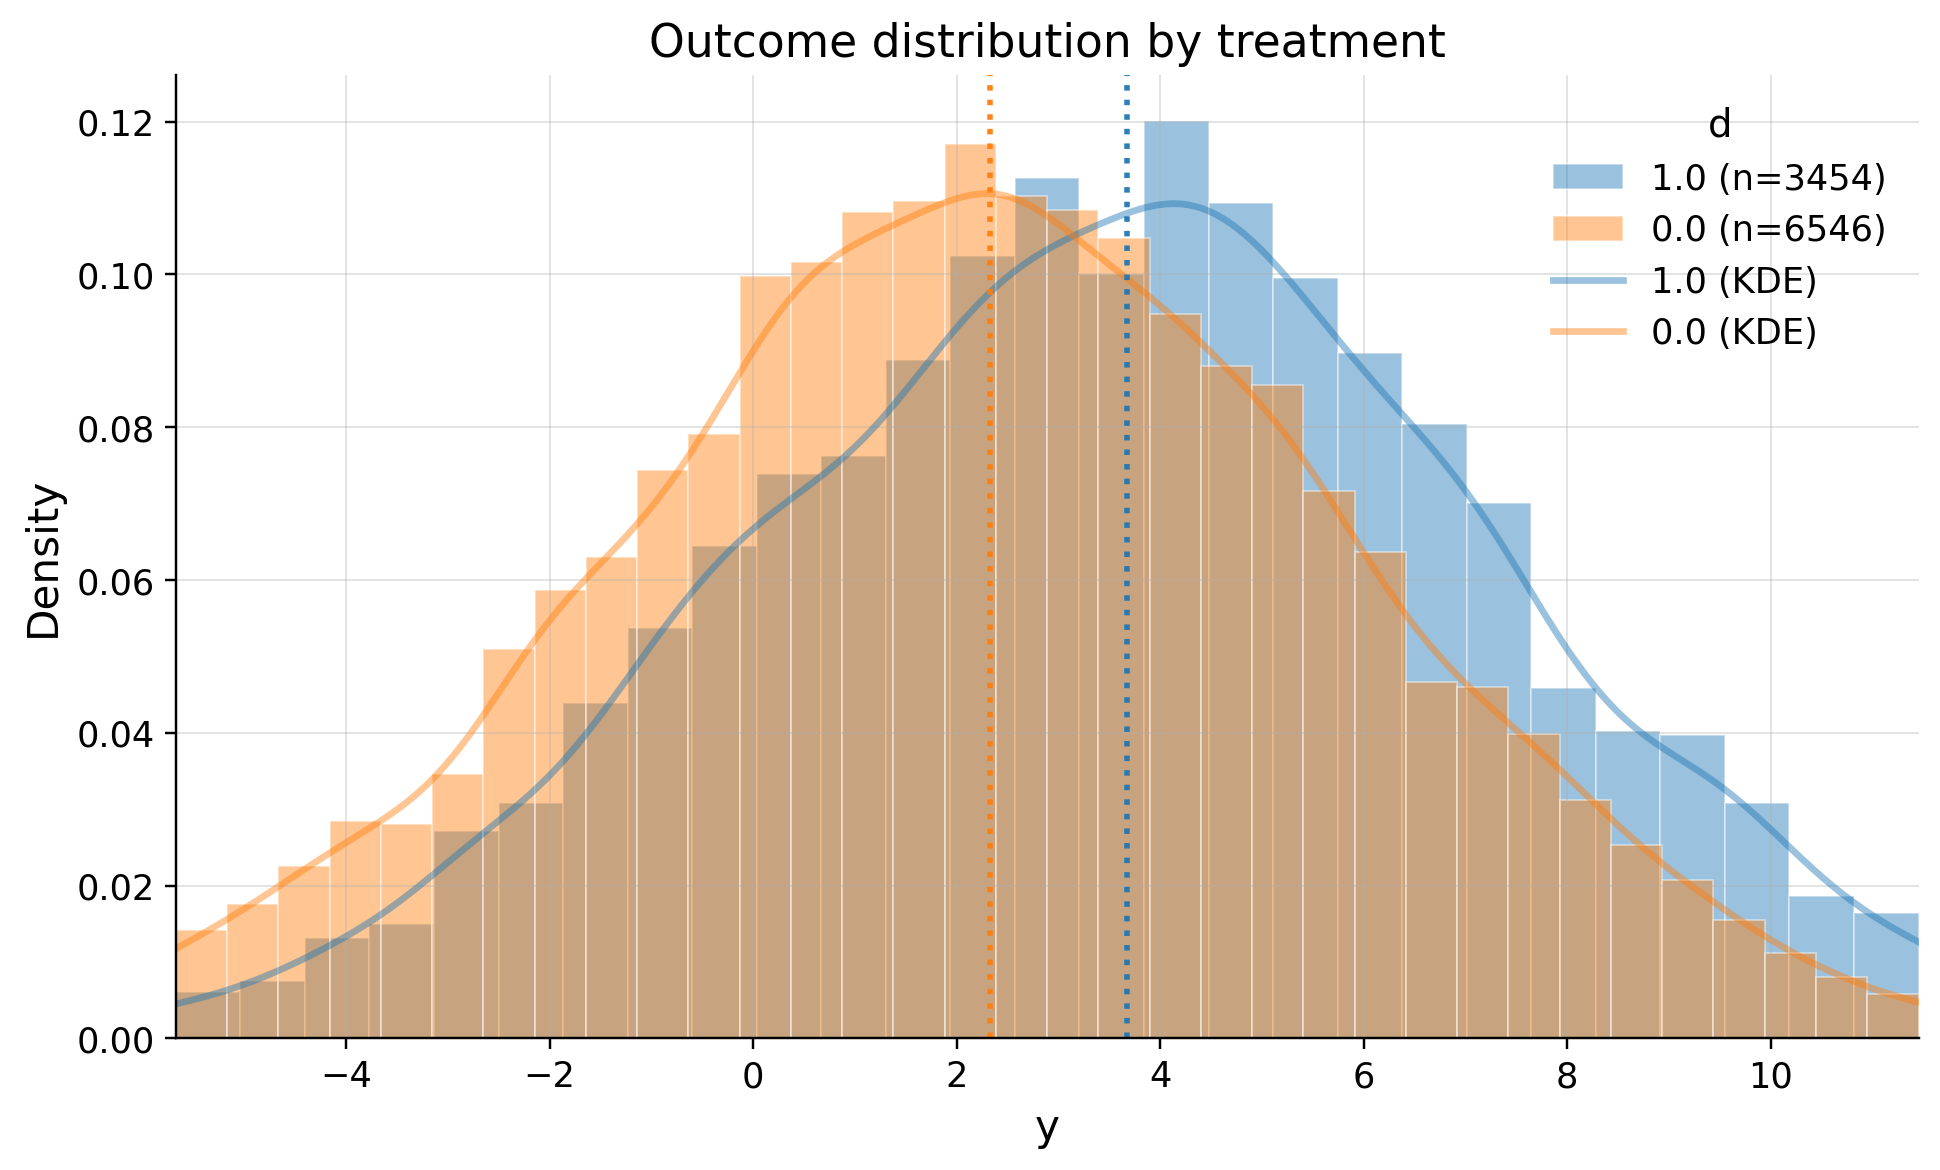

In [5]:
from causalis.shared.outcome_plots import outcome_plot_dist
outcome_plot_dist(causaldata)

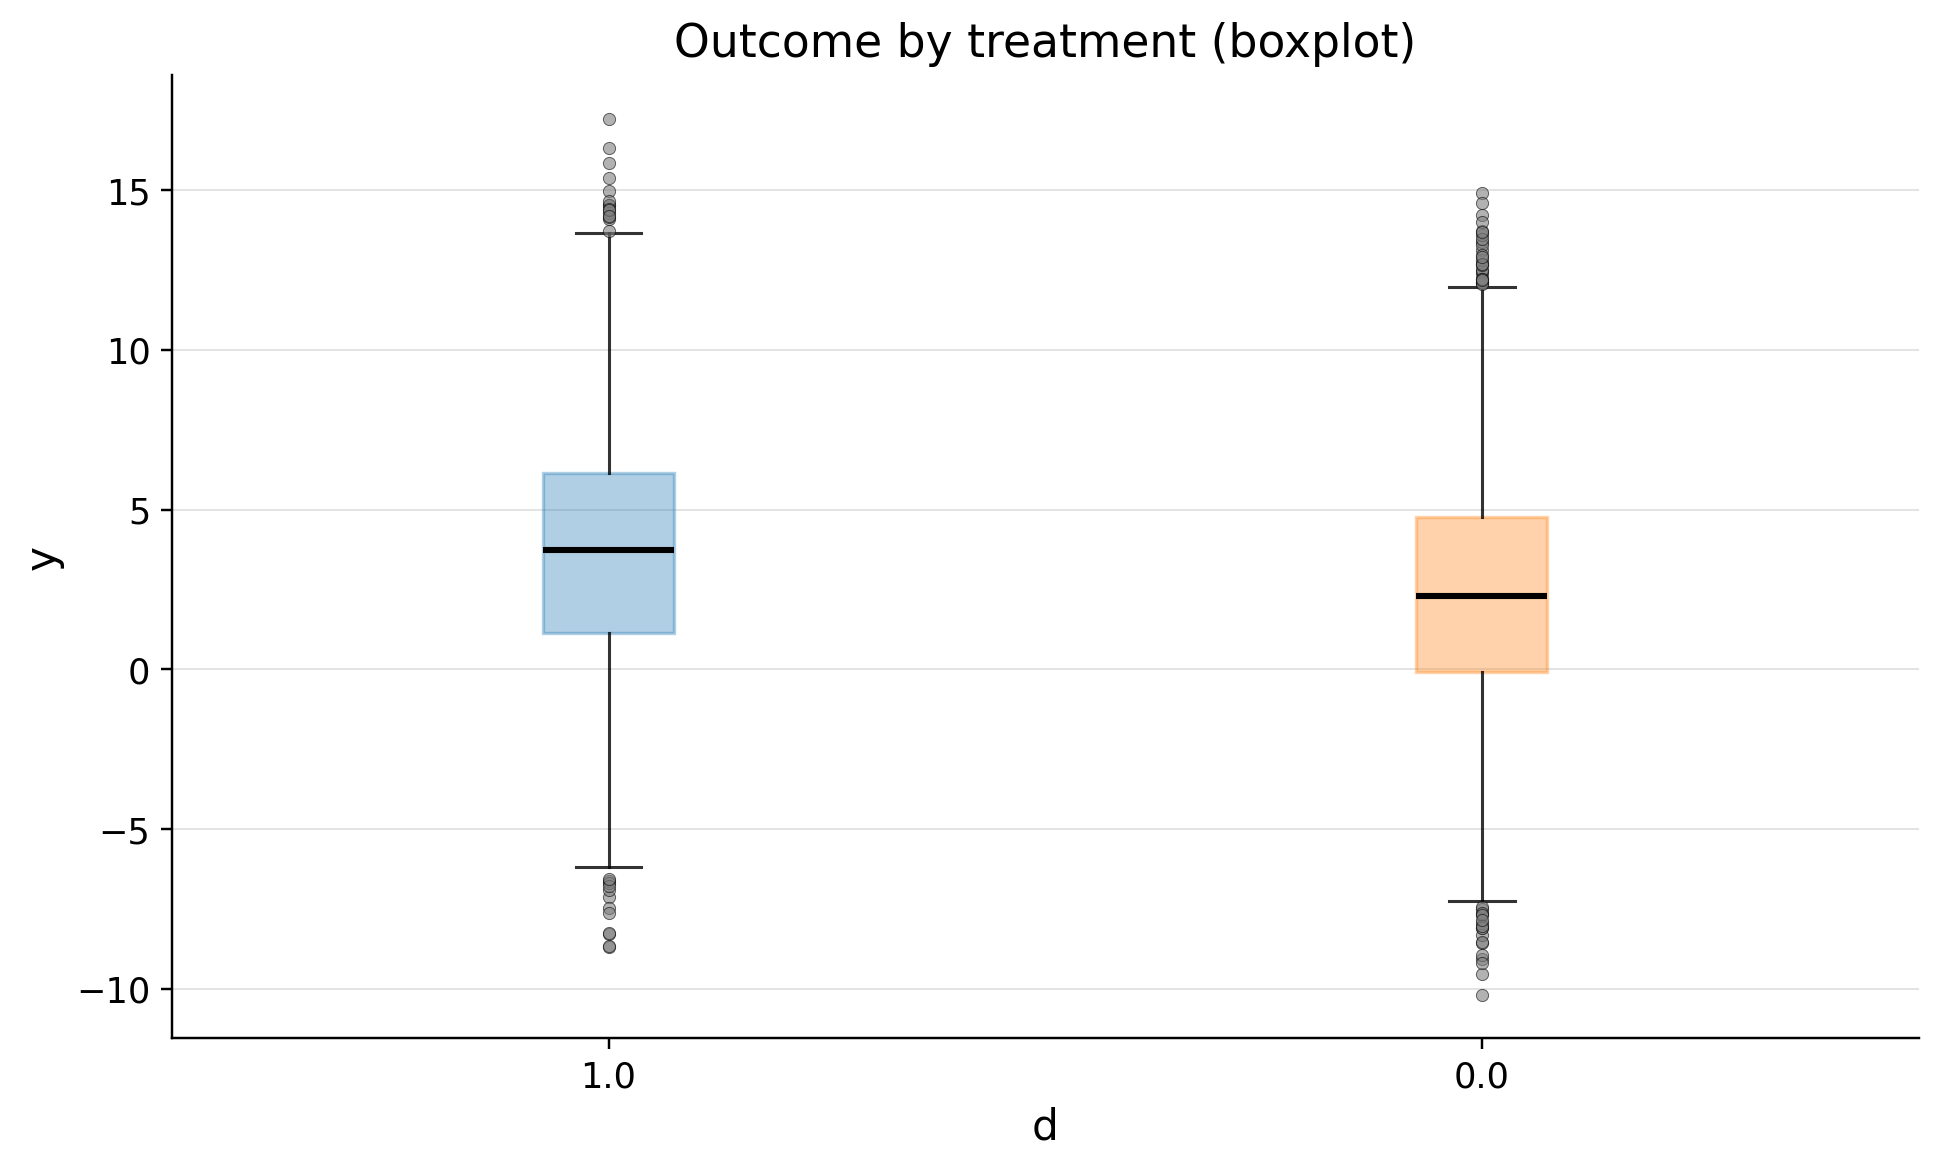

In [6]:
from causalis.shared.outcome_plots import outcome_plot_boxplot
outcome_plot_boxplot(causaldata)

In [7]:
from causalis.shared import confounders_balance

confounders_balance(causaldata)

,confounders,mean_d_0,mean_d_1,abs_diff,smd,ks_pvalue
0,premium_user,0.153682,0.292415,0.138733,0.337945,0.00000
1,avg_sessions_week,4.758326,5.766068,1.007743,0.232927,0.00000
2,tenure_months,27.607954,30.454133,2.846178,0.152969,0.00000
3,urban_resident,0.569814,0.643891,0.074078,0.152080,0.00000


In [18]:
from causalis.shared import outcome_outliers

outcome_outliers(causaldata)

,treatment,n,outlier_count,outlier_rate,lower_bound,upper_bound,has_outliers,method,tail
0,1.0,3454,27,0.007817,-6.353926,13.660217,True,iqr,both
1,0.0,6546,45,0.006874,-7.364670,12.050739,True,iqr,both


# Inference

In [8]:
from causalis.scenarios.unconfoundedness import IRM

model = IRM().fit(causaldata)

### Math Explanation of the IRM Model and ATTE Estimand

The **Interactive Regression Model (IRM)** is a flexible framework used in Double Machine Learning (DML) to estimate treatment effects. Unlike linear models, it allows the treatment effect to vary with confounders $X$ (interaction) and makes no parametric assumptions about the functional forms of the outcomes.

We write $W=(Y,D,X)$ for an observation, where $D\in\{0,1\}$ is treatment and $Y$ is the observed outcome.



#### 1. Nuisance Functions
The IRM framework relies on three "nuisance" components estimated from the data:
*   **Outcome Regression (Control):** $g_0(X) = \mathbb{E}[Y | X, D=0]$
*   **Outcome Regression (Treated):** $g_1(X) = \mathbb{E}[Y | X, D=1]$
*   **Propensity Score:** $m(X) = \mathbb{P}(D=1 | X)$

Let $p = \mathbb{P}(D=1) = \mathbb{E}[D]$ denote the overall treatment rate (estimated by the sample mean of $D$).

In the provided implementation (`irm.py`), these are estimated using cross-fitting (splitting data into folds) to avoid overfitting bias.



#### 2. ATTE (Average Treatment Effect on the Treated)
The **Average Treatment Effect on the Treated (ATTE)** measures the impact of the treatment specifically on those individuals who received it:
$$\theta_{ATTE} = \mathbb{E}[Y(1) - Y(0) \mid D=1]$$

Under **unconfoundedness**, $(Y(1),Y(0)) \perp D \mid X$, and overlap $0 < m(X) < 1$, this is identified from observed data.



#### 3. The Orthogonal Score
DML uses a **Neyman-orthogonal score** $\psi$ to ensure the estimator is robust to small errors in the nuisance function estimates. The score for ATTE is defined as:
$$\psi(W; \theta, \eta) = \psi_b(W; \eta) + \psi_a(W; \eta)\theta$$

To match the implementation in `irm.py`, define:
*   **Residuals:** $u_0 = Y - g_0(X)$, $u_1 = Y - g_1(X)$
*   **IPW terms:** $h_1 = \frac{D}{m(X)}$, $h_0 = \frac{1-D}{1-m(X)}$
*   **Weights (ATTE):** $w = \frac{D}{p}$ and $\bar{w} = \frac{m(X)}{p}$ (the normalized form with $\mathbb{E}[w]=1$)

Then:
$$
\begin{aligned}
\psi_a(W;\eta) &= -w = -\frac{D}{p} \\
\psi_b(W;\eta) &= w\,(g_1(X)-g_0(X)) + \bar{w}\,(u_1 h_1 - u_0 h_0)
\end{aligned}
$$
(If `normalize_ipw=True`, the code rescales $h_1$ and $h_0$ to have mean 1.)



#### 4. Final Estimation (Step-by-step simplification)
For brevity, write $m = m(X)$, $g_0 = g_0(X)$, and $g_1 = g_1(X)$. Plug in $w, \bar{w}, h_1, h_0$:
$$
\begin{aligned} \psi_b &= \frac{D}{p}(g_1-g_0)•
\frac{m}{p}\left[\frac{D}{m}(Y-g_1) - \frac{1-D}{1-m}(Y-g_0)\right] \ &= \frac{D}{p}(g_1-g_0) + \frac{D}{p}(Y-g_1) - \frac{m}{p}\frac{1-D}{1-m}(Y-g_0) \ &= \frac{D}{p}(Y-g_0) - \frac{m}{p}\frac{1-D}{1-m}(Y-g_0). \end{aligned}
$$
So the $g_1(X)$ terms cancel, and the ATTE score depends only on $g_0(X)$ and $m(X)$.
The estimator solves $\mathbb{E}[\psi(W;\theta,\eta)]=0$:

$$
 \begin{aligned} \hat{\theta}_{ATTE} &= \frac{\mathbb{E}[\psi_b]}{\mathbb{E}[-\psi_a]} = \frac{\mathbb{E}[\psi_b]}{\mathbb{E}[D/p]} = \mathbb{E}[\psi_b]. \end{aligned}
 $$
Equivalently,
$$ \hat{\theta}_{ATTE} = \mathbb{E}\left[\frac{D}{p}(Y-g_0(X)) - \frac{m(X)}{p}\frac{1-D}{1-m(X)}(Y-g_0(X))\right]. $$



In [9]:
result = model.estimate(score='ATTE')
result.summary()

,value
field,
estimand,ATTE
model,IRM
value,"1.1184 (ci_abs: 0.9537, 1.2831)"
value_relative,"43.6318 (ci_rel: 36.9899, 50.2737)"
alpha,0.0500
p_value,0.0000
is_significant,True
n_treated,3454
n_control,6546


In [10]:
from causalis.scenarios.unconfoundedness.refutation import *
rep = run_overlap_diagnostics(res=result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.000000,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.151642,GREEN
5,AUC,0.597078,GREEN
6,ESS_treated_ratio,0.880931,GREEN
7,ESS_control_ratio,0.943959,GREEN
8,tails_w1_q99/med,3.425310,GREEN
9,tails_w0_q99/med,3.601122,GREEN


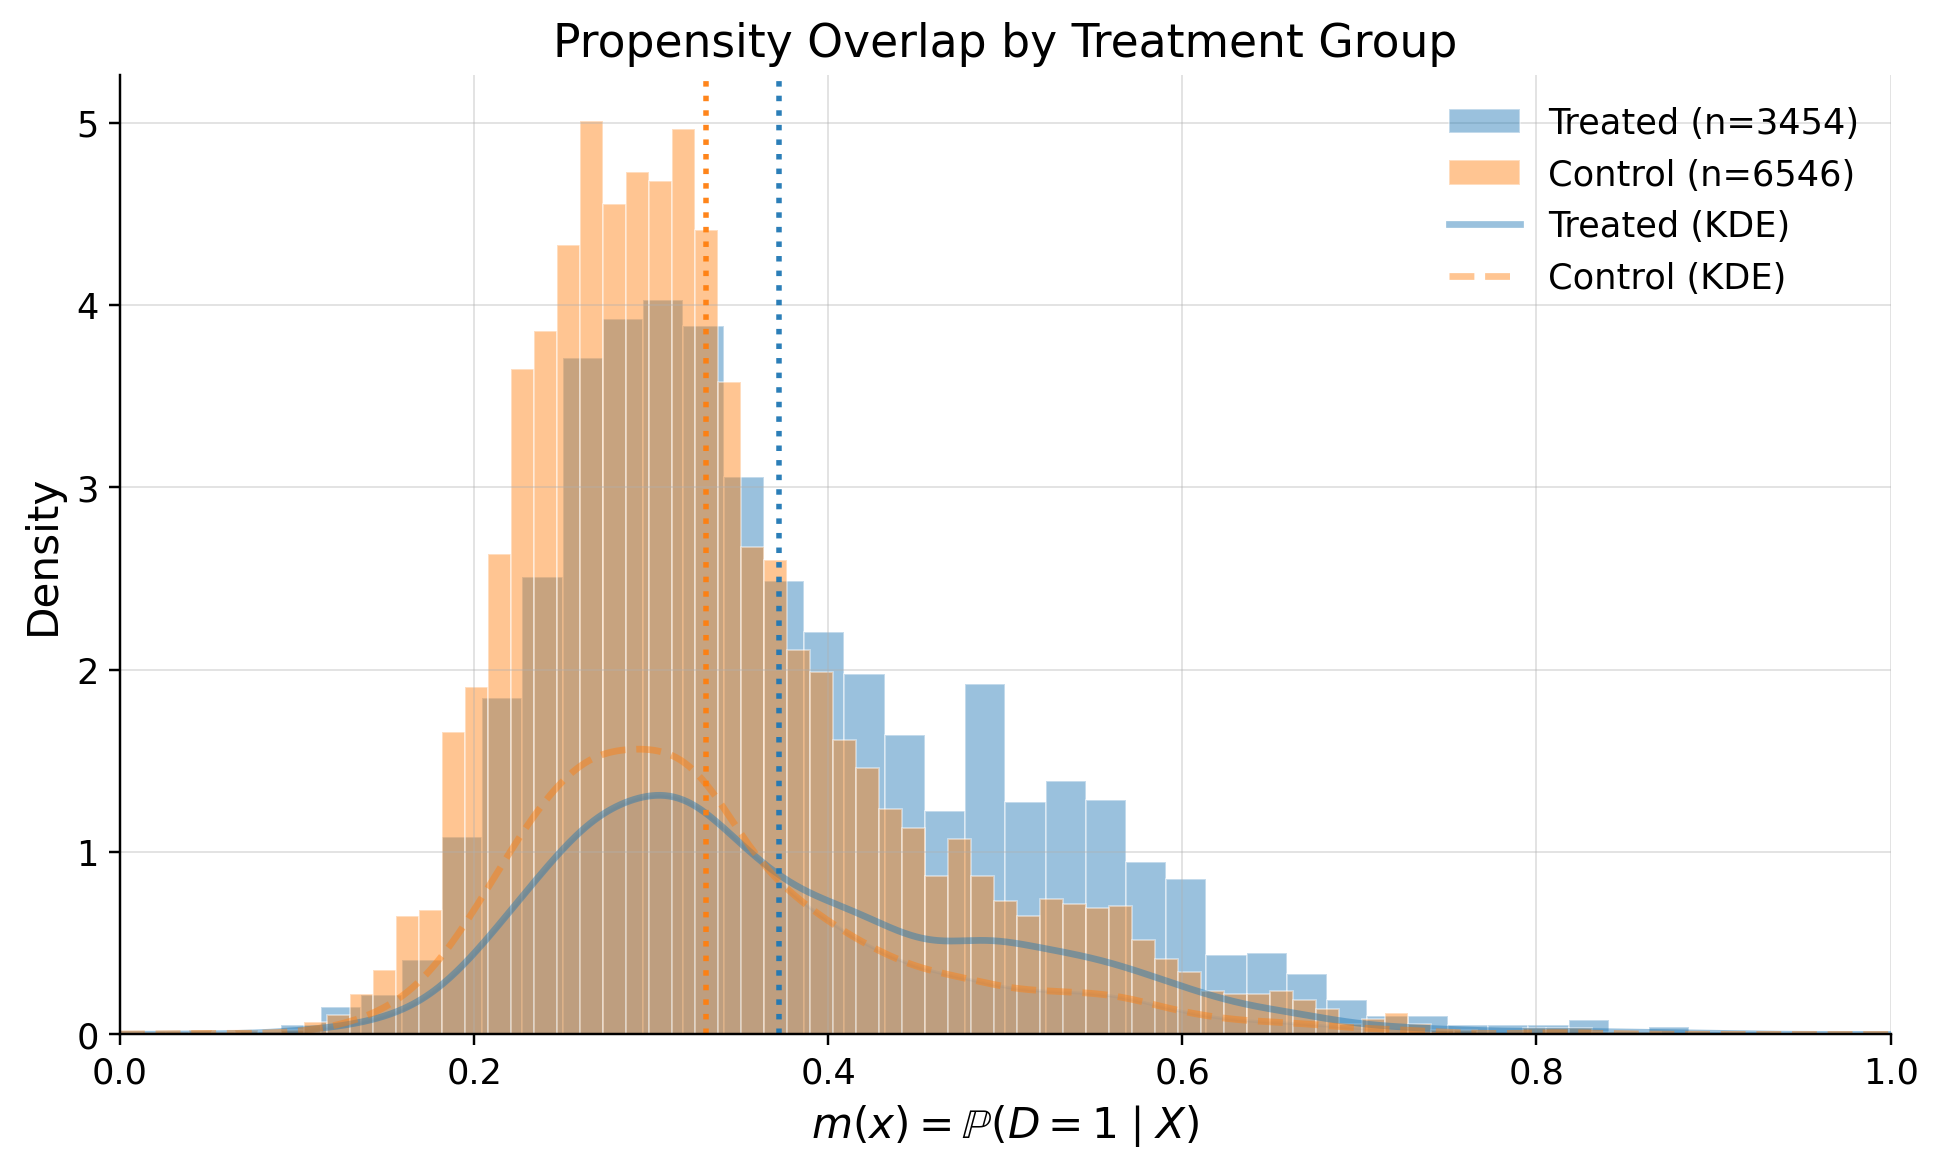

In [11]:
plot_m_overlap(result.diagnostic_data)

In [12]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,0.084014,NA
1,psi_p99_over_med,6.487127,GREEN
2,psi_kurtosis,9.286288,GREEN
3,max_|t|_g1,0.000000,GREEN
4,max_|t|_g0,1.912414,GREEN
5,max_|t|_m,0.113460,GREEN


In [14]:
from causalis.shared import print_sutva_questions
print_sutva_questions()

1.) Are your clients independent (i). Outcome of ones do not depend on others?
2.) Are all clients have full window to measure metrics?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


In [15]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.uncofoundedness_validation import run_uncofoundedness_diagnostics

rep_uc = run_uncofoundedness_diagnostics(res=result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.028075,GREEN
1,balance_frac_violations,0.000000,GREEN


In [16]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(result, r2_y=0.01, r2_d=0.01, rho=1.0, alpha=0.05)

{'theta': 1.1184152623839168,
 'se': 0.08401446946299296,
 'alpha': 0.05,
 'z': 1.959963984540054,
 'H0': 0.0,
 'sampling_ci': (0.9537499280562104, 1.2830805967116232),
 'theta_bounds_cofounding': (1.0390825135165902, 1.1977480112512433),
 'bias_aware_ci': (0.8745313310339287, 1.3625431964436676),
 'max_bias': 0.07933274886732654,
 'sigma2': 13.135090018715454,
 'nu2': 4.6961541197697105,
 'rv': 0.12465121622917608,
 'rva': 0.10828602100502939,
 'params': {'r2_y': 0.01, 'r2_d': 0.01, 'rho': 1.0, 'use_signed_rr': False}}

In [17]:
sensitivity_benchmark(result.diagnostic_data, benchmarking_set =['tenure_months'])

,r2_y,r2_d,rho,theta_long,theta_short,delta
d,0.000005,0.127177,1.0,1.118415,1.101774,0.016641
